# Convolutional Variational Autoencoder for Topology Optimization

## Introduction and Theory

Variational Autoencoders (VAEs) are powerful generative models that learn to encode data into a lower-dimensional latent space and then reconstruct it. In the context of topology optimization, we're particularly interested in learning meaningful representations of structural designs that can be manipulated and interpolated.

The key idea behind VAEs is based on the following probability model:

$p(x|z) = \mathcal{N}(f_\theta(z), \sigma^2I)$  (decoder/likelihood)
$p(z) = \mathcal{N}(0, I)$           (prior)
$q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma_\phi(x)^2)$  (encoder/approximate posterior)

where:
- $x$ is our input topology design
- $z$ is the latent space variable
- $\theta$ and $\phi$ are the neural network parameters
- $f_\theta$ represents our decoder network
- $\mu_\phi$ and $\sigma_\phi$ are outputs of our encoder network


We first import the required library. We will use torch for the Neural Network definition and training.## Required Libraries Setup

First, install the required Python packages. You can use pip to install them:

```bash
pip install torch torchvision
pip install numpy matplotlib
pip install scikit-learn


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split



## Image Preprocessing for Convolutional VAE

Before training our Convolutional VAE, we need to properly preprocess our topology optimization images. 
### Image Resizing and Standardization

We resize all images to 128x128 pixels for several important reasons:
- Powers of 2 are optimal for convolutional operations (we do not need to use extra operation such as padding..)
- Consistent dimensions are required for batch processing
- This is typical to natural images where Convolutional Neural Nets are normally applied.


You will need to properly specify the data_path where you store the original mages and the output folder where you will save the resized images.


Created output directory: Dataset_TopOpt/images_topopt_2/images_128x128
Found 4896 files in Dataset_TopOpt/images_topopt_2/
Processed 10/4896 images
Processed 20/4896 images
Processed 30/4896 images
Processed 40/4896 images
Processed 50/4896 images
Processed 60/4896 images
Processed 70/4896 images
Processed 80/4896 images
Processed 90/4896 images
Processed 100/4896 images
Processed 110/4896 images
Processed 120/4896 images
Processed 130/4896 images
Processed 140/4896 images
Processed 150/4896 images
Processed 160/4896 images
Processed 170/4896 images
Processed 180/4896 images
Processed 190/4896 images
Processed 200/4896 images
Processed 210/4896 images
Processed 220/4896 images
Processed 230/4896 images
Processed 240/4896 images
Processed 250/4896 images
Processed 260/4896 images
Processed 270/4896 images
Processed 280/4896 images
Processed 290/4896 images
Processed 300/4896 images
Processed 310/4896 images
Processed 320/4896 images
Processed 330/4896 images
Processed 340/4896 images
P

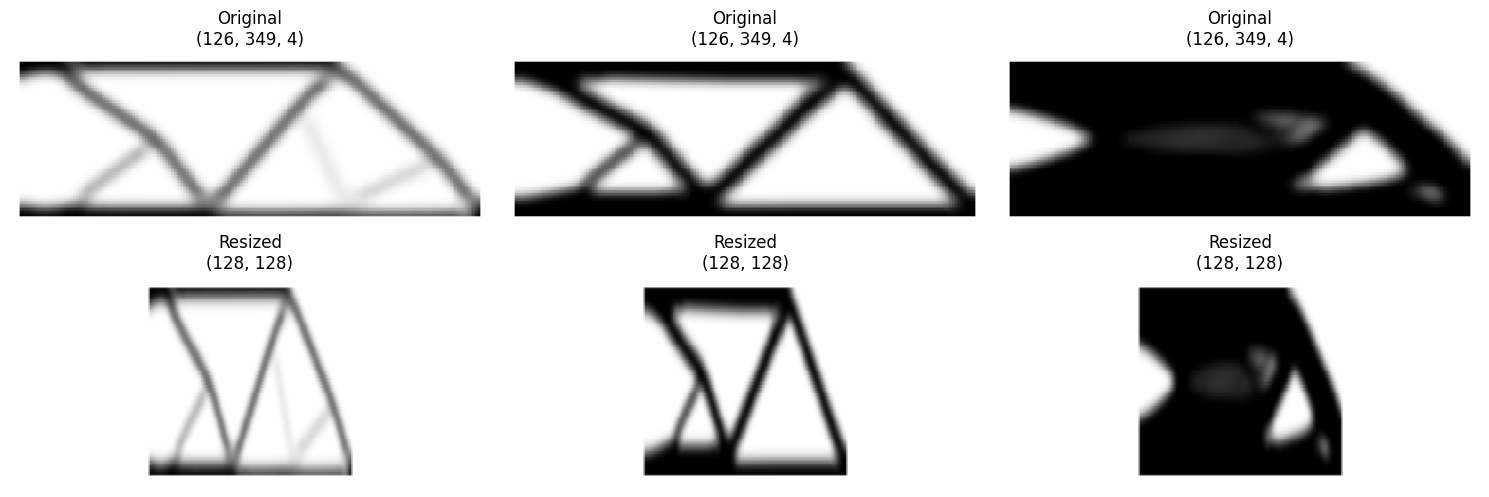

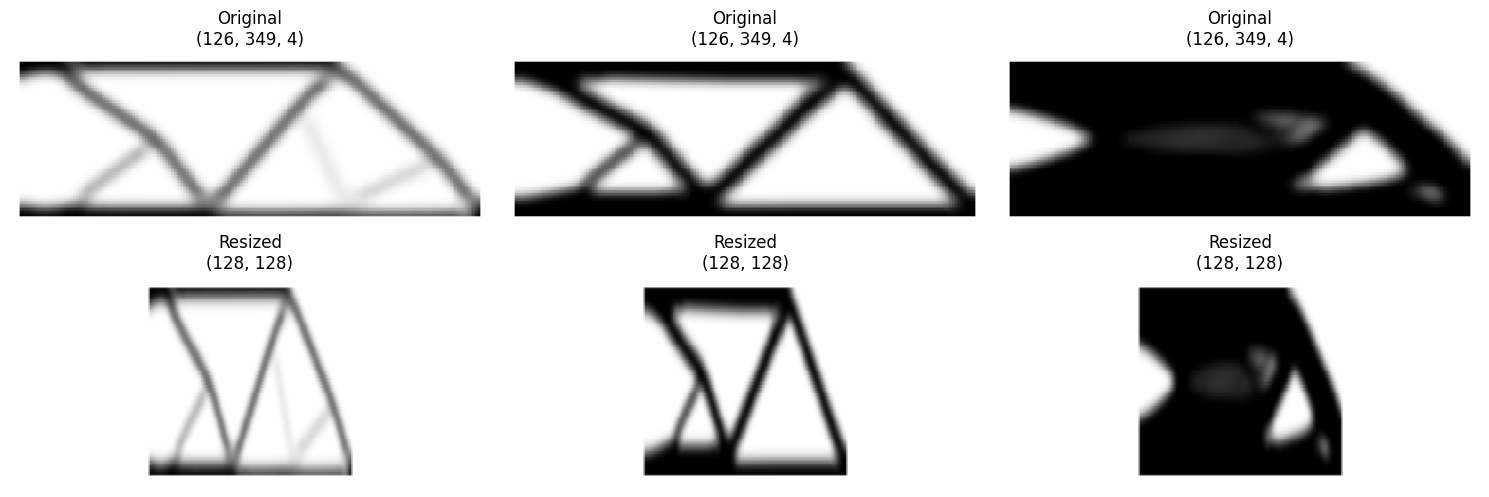

In [10]:
import os
from PIL import Image
import numpy as np
from torchvision import transforms
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def resize_and_save_images(data_path='Dataset_TopOpt/images_topopt_2/', output_folder='images_128x128'):
    """
    Resize all images to 128x128 and save them in a new directory
    """
    # Create output directory as a subfolder in the same parent directory as input
    parent_dir = os.path.dirname(data_path)
    output_path = os.path.join(parent_dir, output_folder)
    
    # Create output directory if it doesn't exist
    if os.path.exists(output_path):
        shutil.rmtree(output_path)  # Remove if exists
    os.makedirs(output_path)
    print(f"Created output directory: {output_path}")
    
    # Setup image transform
    transform = transforms.Compose([
        transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor()
    ])
    
    # Process each image
    file_names = glob.glob(os.path.join(data_path, '*.*'))  # Handle any image extension
    print(f"Found {len(file_names)} files in {data_path}")
    
    if not file_names:
        raise ValueError(f"No image files found in {data_path}")
    
    for i, file_name in enumerate(file_names):
        try:
            # Load image
            img = Image.open(file_name)
            
            # Convert to grayscale if not already
            if img.mode != 'L':
                img = img.convert('L')
            
            # Resize image
            img_resized = transform(img)
            
            # Convert to numpy and save
            img_np = (img_resized.numpy()[0] * 255).astype(np.uint8)
            
            # Get original filename with original extension
            original_filename = os.path.basename(file_name)
            
            # Save resized image
            output_file = os.path.join(output_path, original_filename)
            Image.fromarray(img_np).save(output_file)
            
            # Print progress
            if (i + 1) % 10 == 0:
                print(f'Processed {i + 1}/{len(file_names)} images')
                
        except Exception as e:
            print(f"Error processing {file_name}: {str(e)}")
    
    print(f'\nAll images have been resized and saved to {output_path}')
    return output_path

def display_sample_pairs(original_path, resized_path, n_samples=3):
    """Display pairs of original and resized images"""
    # Get list of files that exist in both directories
    original_files = set(os.listdir(original_path))
    resized_files = set(os.listdir(resized_path))
    common_files = list(original_files.intersection(resized_files))
    
    if not common_files:
        raise ValueError("No matching files found in both directories")
    
    # Take only the first n_samples files
    files_to_display = common_files[:n_samples]
    
    plt.figure(figsize=(15, 5))
    for i, fname in enumerate(files_to_display):
        try:
            # Original image
            orig_path = os.path.join(original_path, fname)
            if os.path.exists(orig_path):
                plt.subplot(2, n_samples, i + 1)
                img_orig = mpimg.imread(orig_path)
                plt.imshow(img_orig, cmap='gray')
                plt.title(f'Original\n{img_orig.shape}')
                plt.axis('off')
            
            # Resized image
            resized_path_full = os.path.join(resized_path, fname)
            if os.path.exists(resized_path_full):
                plt.subplot(2, n_samples, i + 1 + n_samples)
                img_resized = mpimg.imread(resized_path_full)
                plt.imshow(img_resized, cmap='gray')
                plt.title(f'Resized\n{img_resized.shape}')
                plt.axis('off')
                
        except Exception as e:
            print(f"Error displaying {fname}: {str(e)}")
    
    plt.tight_layout()
    plt.show()

# Execute the resizing with proper paths
input_path = 'Dataset_TopOpt/images_topopt_2/'
new_data_path = resize_and_save_images(input_path)

# Print the paths to verify
print(f"Input path: {input_path}")
print(f"Output path: {new_data_path}")

# Display some samples with proper paths
try:
    display_sample_pairs(input_path, new_data_path)
except Exception as e:
    print(f"Error displaying samples: {str(e)}")

# Display some samples
display_sample_pairs('Dataset_TopOpt/images_topopt_2/', new_data_path)

## Data Loading and Dataset Organization

The data loading and organization pipeline consists of three main components:

### Custom Dataset Class

The `TopologyDataset` class inherits from PyTorch's Dataset class and handles the organization of our topology optimization data. It reformats our images into the proper shape for convolutional networks (batch_size, channels, height, width) and converts both images and labels to PyTorch tensors. Each image is reshaped to 128x128 pixels with a single channel for grayscale values.

### Grayscale Conversion

The `rgb2gray` function handles the conversion of RGB images to grayscale using standard luminance weights. This conversion preserves the important structural information while reducing the dimensionality of our data. The weights (0.2989, 0.5870, 0.1140) correspond to the human perception of color intensity for red, green, and blue channels respectively.

### Data Loading Function

The `load_data` function implements the main data loading pipeline. It reads images from the specified directory, processes them (either converting from RGB to grayscale or normalizing existing grayscale images), and extracts corresponding labels from the filenames. Labels in our case represent two parameters encoded in the filename structure. The function handles both RGB and grayscale inputs, normalizes all pixel values to the range [0,1], and returns numpy arrays ready for dataset creation.

In [11]:
class TopologyDataset(Dataset):
    """Custom Dataset for topology optimization images"""
    def __init__(self, images, labels):
        # Reshape images to (batch_size, channels, height, width) - now 128x128
        self.images = torch.FloatTensor(images).reshape(-1, 1, 128, 128)
        self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
def rgb2gray(rgb):
    """Convert RGB image to grayscale and normalize"""
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])/255.0

def load_data(data_path='Dataset_TopOpt/images_128x128/'):
    """Load and preprocess topology optimization images"""
    file_names = glob.glob(data_path + '*.jpg')
    images = []
    labels = []
    
    # Load images and labels
    for file_name in file_names:
        img = mpimg.imread(file_name)
        if len(img.shape) == 3:  # If RGB
            img = rgb2gray(img)
        else:  # If already grayscale
            img = img / 255.0  # Normalize
        images.append(img)
        
        # Extract labels from filename
        tmp = file_name.split('_')
        labels.append([int(tmp[-2]), int(tmp[-1][:-4])])
    
    # Convert to numpy arrays
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    
    return images, labels




## Convolutional Variational Autoencoder Architecture

The CVAE architecture implements a conditional variational autoencoder using convolutional layers.
### Convolutional Operations

A convolution operation between an input $I$ and a kernel $K$ is defined as: $(I * K)_{i,j} = \sum_{m} \sum_{n} I_{m,n} K_{i-m,j-n}$

Elements:
- **Kernel**: Small filter matrix that slides across the input
- **Stride**: Step size for sliding the kernel (stride=2 halves dimensions)
- **Padding**: Extra pixels added to borders (padding=1 preserves spatial dimensions)

### Network Architecture

#### Encoder Path (Dimensionality Reduction)
- Progressive downsampling through convolutions: $128 \times 128 \to 64 \times 64 \to 32 \times 32 \to 16 \times 16 \to 8 \times 8$
- The encoder outputs parameters of the approximate posterior: $q_\phi(z|x,c) = \mathcal{N}(\mu_\phi(x,c), \sigma_\phi(x,c))$
- $\mu$: mean of latent distribution
- $\log \sigma^2$: log variance of latent distribution

#### Decoder Path (Dimensionality Expansion)
- Input: Sampled latent vector $z$ concatenated with condition $c$
- Progressive upsampling through transposed convolutions: $8 \times 8 \to 16 \times 16 \to 32 \times 32 \to 64 \times 64 \to 128 \times 128$
- Likelihood: $p_\theta(x|z,c)$ parameterized by decoder network

Sampling uses the reparameterization trick:
$z = \mu + \sigma \odot \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

In [17]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(CVAE, self).__init__()
        
        # Architecture parameters
        self.latent_dim = latent_dim
        self.hidden_dims = [32, 64, 128, 256]  # Number of channels in conv layers
        
        # Calculate final output size after convolutions
        # For 128x128 input, after 4 conv layers with stride 2:
        # 128 -> 64 -> 32 -> 16 -> 8
        self.h_dim = self.hidden_dims[-1] * (8 * 8)  # 256 * 64 = 16384
        
        # Encoder
        self.encoder = nn.ModuleList()
        in_channels = 1  # Grayscale images
        
        for h_dim in self.hidden_dims:
            self.encoder.extend([
                nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(h_dim),
                nn.LeakyReLU()
            ])
            in_channels = h_dim
            
        # Latent space
        self.fc_mu = nn.Linear(self.h_dim + 1, latent_dim)  # +1 for condition
        self.fc_var = nn.Linear(self.h_dim + 1, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim + 1, self.h_dim)  # +1 for condition
        
        # Decoder
        self.decoder = nn.ModuleList()
        self.hidden_dims.reverse()  # Reverse for decoder
        
        for i in range(len(self.hidden_dims) - 1):
            self.decoder.extend([
                nn.ConvTranspose2d(
                    self.hidden_dims[i],
                    self.hidden_dims[i + 1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1
                ),
                nn.BatchNorm2d(self.hidden_dims[i + 1]),
                nn.LeakyReLU()
            ])
        
        # Final layer to get back to image size
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                self.hidden_dims[-1],
                self.hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),
            nn.BatchNorm2d(self.hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(self.hidden_dims[-1], out_channels=1,
                     kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        """
        Encode input to latent space parameters
        
        Args:
            x (torch.Tensor): Input image tensor [B, 1, 128, 128]
            c (torch.Tensor): Condition tensor [B, 1]
            
        Returns:
            tuple: (mu, log_var) of latent space parameters
        """
        # Pass through encoder layers
        for layer in self.encoder:
            x = layer(x)
            
        # Flatten and concatenate with condition
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], dim=1)
        
        # Get latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var
    
    def decode(self, z, c):
        """
        Decode latent vector to image
        
        Args:
            z (torch.Tensor): Latent vector [B, latent_dim]
            c (torch.Tensor): Condition tensor [B, 1]
            
        Returns:
            torch.Tensor: Reconstructed image [B, 1, 128, 128]
        """
        # Concatenate latent vector with condition
        z = torch.cat([z, c], dim=1)
        
        # Initial linear layer
        x = self.decoder_input(z)
        
        # Reshape to starting decoder dimensions (8x8)
        x = x.view(x.size(0), self.hidden_dims[0], 8, 8)
        
        # Pass through decoder layers
        for layer in self.decoder:
            x = layer(x)
            
        # Final layer
        x = self.final_layer(x)
        return x
    
    def reparameterize(self, mu, log_var):
        """
        Sample from latent space using reparameterization trick
        
        Args:
            mu (torch.Tensor): Mean of latent distribution
            log_var (torch.Tensor): Log variance of latent distribution
            
        Returns:
            torch.Tensor: Sampled latent vector
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, c):
        """
        Forward pass through the VAE
        
        Args:
            x (torch.Tensor): Input image tensor [B, 1, 128, 128]
            c (torch.Tensor): Condition tensor [B, 1]
            
        Returns:
            tuple: (reconstruction, mu, log_var)
        """
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var
    
    def generate(self, num_samples, condition, device):
        """
        Generate new images from random latent vectors
        
        Args:
            num_samples (int): Number of images to generate
            condition (float): Condition value
            device: torch device
            
        Returns:
            torch.Tensor: Generated images [num_samples, 1, 128, 128]
        """
        with torch.no_grad():
            # Sample latent vectors
            z = torch.randn(num_samples, self.latent_dim).to(device)
            
            # Prepare condition
            c = torch.ones(num_samples, 1).to(device) * condition
            
            # Generate images
            return self.decode(z, c)
    
    def interpolate(self, z1, z2, condition, steps=10, device='cpu'):
        """
        Interpolate between two latent vectors
        
        Args:
            z1 (torch.Tensor): First latent vector
            z2 (torch.Tensor): Second latent vector
            condition (float): Condition value
            steps (int): Number of interpolation steps
            device: torch device
            
        Returns:
            torch.Tensor: Interpolated images [steps, 1, 128, 128]
        """
        with torch.no_grad():
            # Create interpolation steps
            alphas = torch.linspace(0, 1, steps).to(device)
            
            # Interpolate in latent space
            z_interp = torch.stack([
                z1 * (1 - alpha) + z2 * alpha
                for alpha in alphas
            ])
            
            # Prepare condition
            c = torch.ones(steps, 1).to(device) * condition
            
            # Generate images
            return self.decode(z_interp, c)

## VAE Training and Loss Functions

The training process for our CVAE optimizes two main objectives, balanced through a β parameter:

### Loss Components

1. **Reconstruction Loss (MSE)**
  - Measures how well the decoder reconstructs the input image
  - Mean Squared Error between input $x$ and reconstruction $\hat{x}$:
  $\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{x}_i)^2$

2. **KL Divergence Loss**
  - Ensures latent distribution matches prior $\mathcal{N}(0,I)$
  - For Gaussian distributions, has closed form:
  $\mathcal{L}_{KL} = -\frac{1}{2} \sum_{i=1}^d (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2)$

3. **Combined Loss**
  - Weighted sum with β parameter:
  $\mathcal{L}_{total} = \mathcal{L}_{MSE} + \beta \mathcal{L}_{KL}$
  - β controls trade-off between reconstruction quality and latent space regularization

The ELBO (Evidence Lower BOund) being maximized is:
$\mathcal{L}_{ELBO} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \cdot KL(q_\phi(z|x)||p(z))$

In [22]:
def train_cvae(model, train_loader, optimizer, device, epochs=50, beta=0.01, save_path=None):
    """
    Train the CVAE model
    
    Args:
        model: CVAE model
        train_loader: DataLoader for training data
        optimizer: Optimizer instance
        device: torch device
        epochs: Number of training epochs
        beta: Weight for KL divergence loss
        save_path: Path to save model checkpoints (optional)
    """
    model.train()
    
    # Lists to store losses for plotting
    epoch_losses = []
    epoch_mse_losses = []
    epoch_kld_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        total_mse = 0
        total_kld = 0
        
        for batch_idx, (data, conditions) in enumerate(train_loader):
            data = data.to(device)
            conditions = conditions.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data, conditions)
            
            # Calculate losses
            mse = F.mse_loss(recon_batch, data, reduction='mean')
            kld = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
            loss = mse + beta * kld
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_mse += mse.item()
            total_kld += kld.item()
            
                
            # Visualize first image in batch periodically
            if batch_idx % 400 == 0:
                with torch.no_grad():
                    # Original and reconstruction
                    orig = data[0].cpu().squeeze().numpy()
                    recon = recon_batch[0].cpu().squeeze().numpy()
                    
                    plt.figure(figsize=(10, 4))
                    plt.subplot(121)
                    plt.imshow(orig, cmap='gray')
                    plt.title('Original')
                    plt.axis('off')
                    
                    plt.subplot(122)
                    plt.imshow(recon, cmap='gray')
                    plt.title('Reconstruction')
                    plt.axis('off')
                    plt.show()
        
        # Calculate average losses for epoch
        n_batches = len(train_loader)
        avg_loss = total_loss / n_batches
        avg_mse = total_mse / n_batches
        avg_kld = total_kld / n_batches
        
        # Store losses for plotting
        epoch_losses.append(avg_loss)
        epoch_mse_losses.append(avg_mse)
        epoch_kld_losses.append(avg_kld)
        
        # Print epoch statistics
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'  Average loss = {avg_loss:.6f}')
        print(f'  MSE = {avg_mse:.6f}')
        print(f'  KL Divergence = {avg_kld:.6f}')
        print(f'  Beta*KLD = {(beta*avg_kld):.6f}')
        print('-' * 50)
        
        # Save model checkpoint
        if save_path and (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'beta': beta
            }
            torch.save(checkpoint, f'{save_path}/cvae_epoch_{epoch+1}.pt')
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.plot(epoch_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(132)
    plt.plot(epoch_mse_losses)
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(133)
    plt.plot(epoch_kld_losses)
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    return epoch_losses, epoch_mse_losses, epoch_kld_losses

### Let's do it

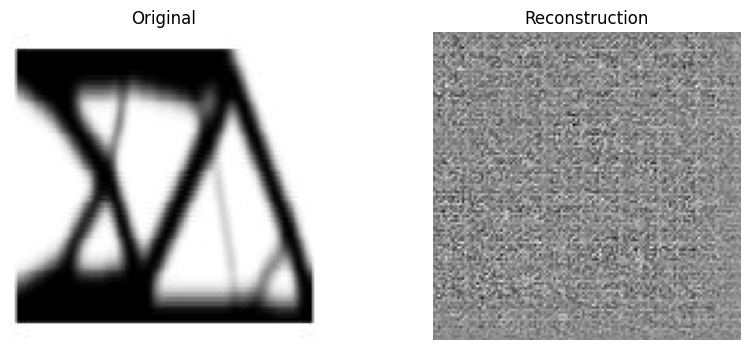

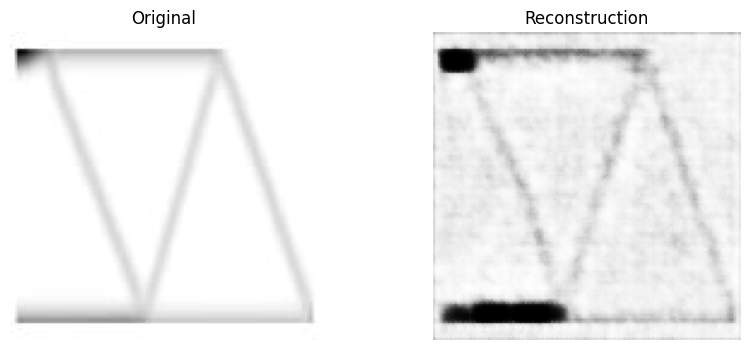

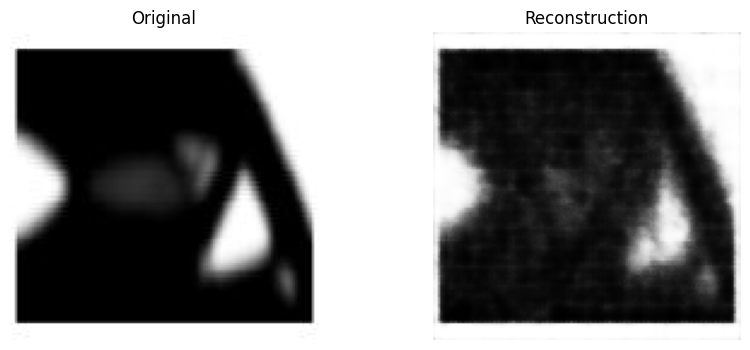


Epoch 1/5:
  Average loss = 0.045319
  MSE = 0.040571
  KL Divergence = 0.474848
  Beta*KLD = 0.004748
--------------------------------------------------


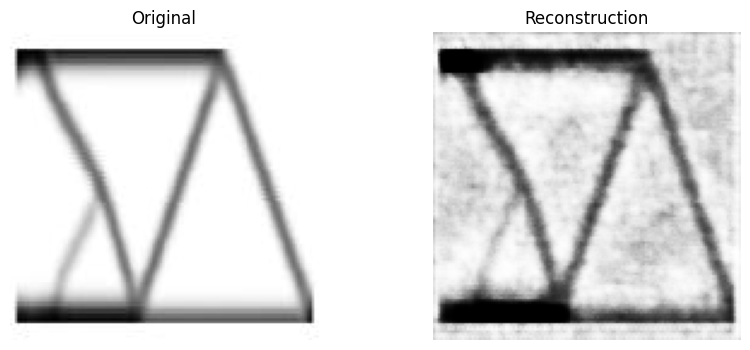

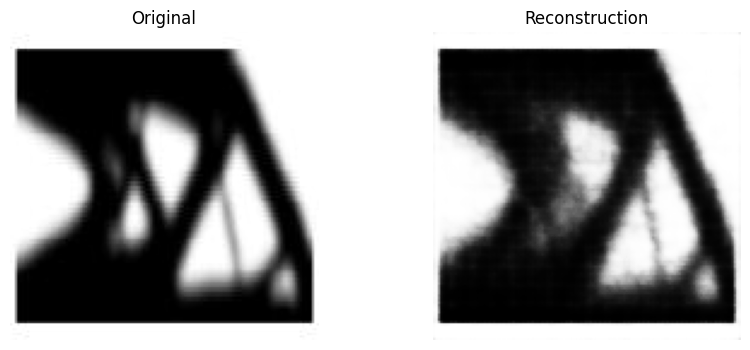

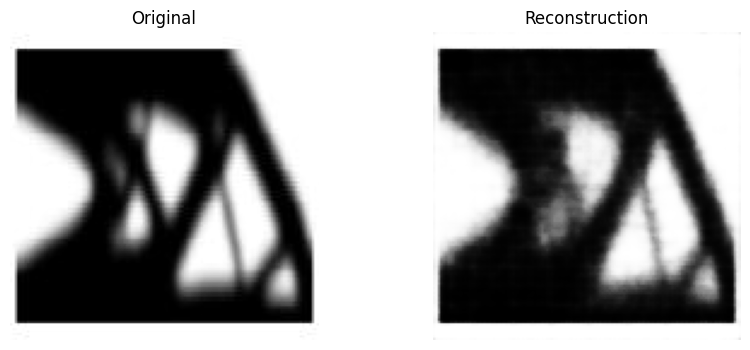


Epoch 2/5:
  Average loss = 0.012688
  MSE = 0.010195
  KL Divergence = 0.249290
  Beta*KLD = 0.002493
--------------------------------------------------


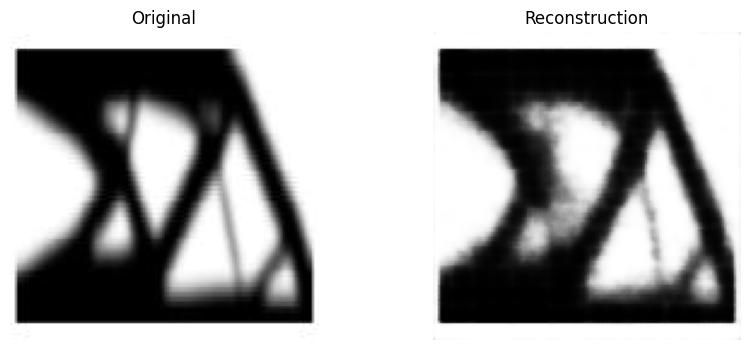

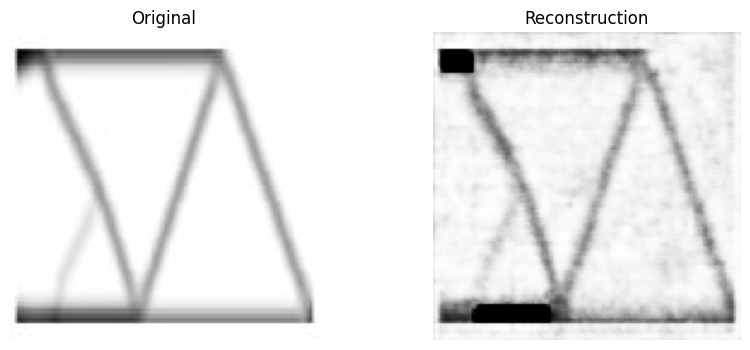

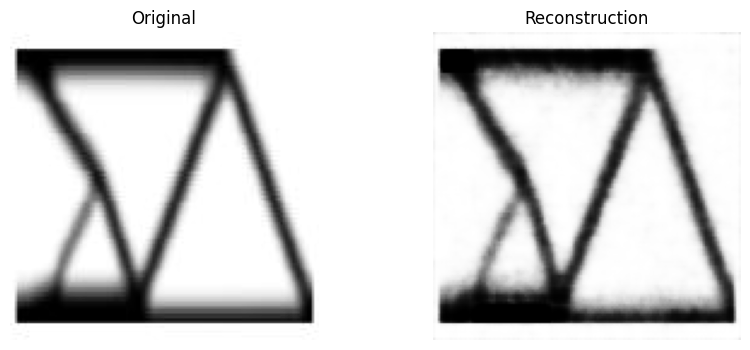


Epoch 3/5:
  Average loss = 0.009904
  MSE = 0.007505
  KL Divergence = 0.239864
  Beta*KLD = 0.002399
--------------------------------------------------


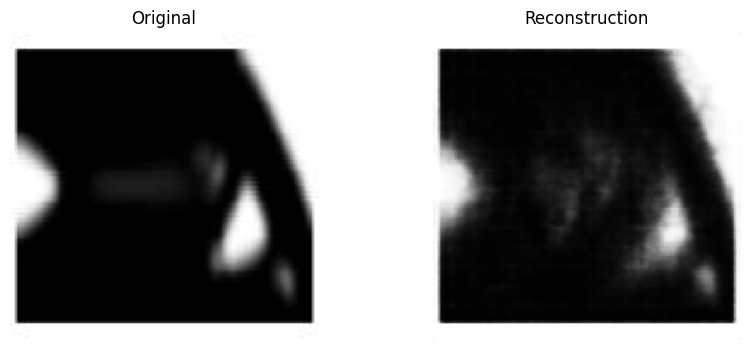

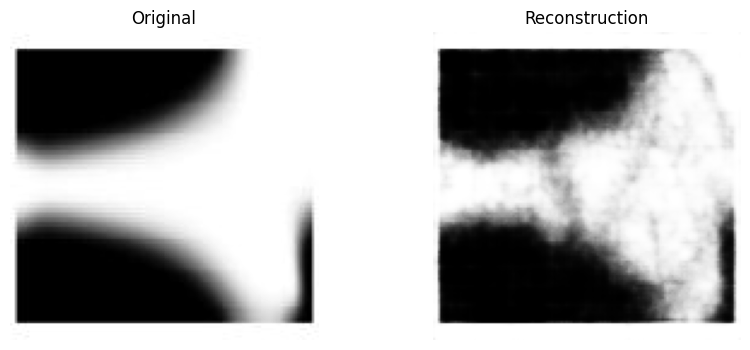

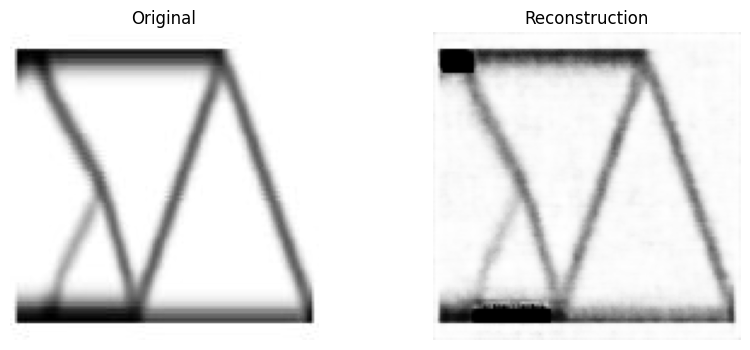


Epoch 4/5:
  Average loss = 0.008716
  MSE = 0.006328
  KL Divergence = 0.238848
  Beta*KLD = 0.002388
--------------------------------------------------


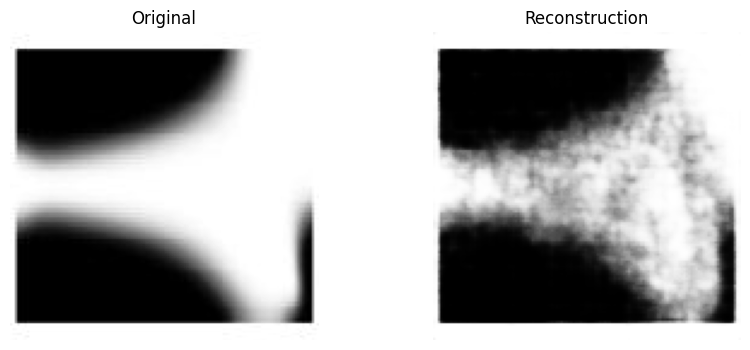

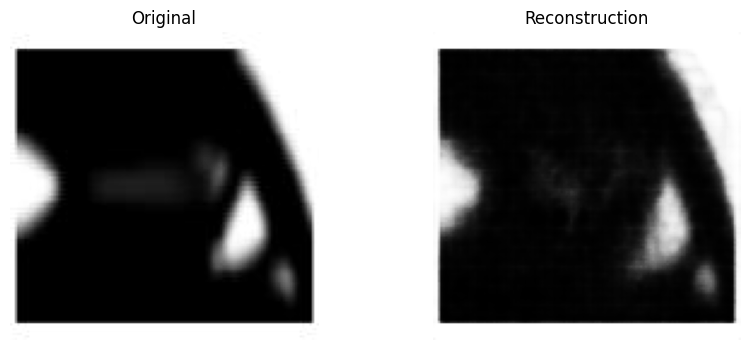

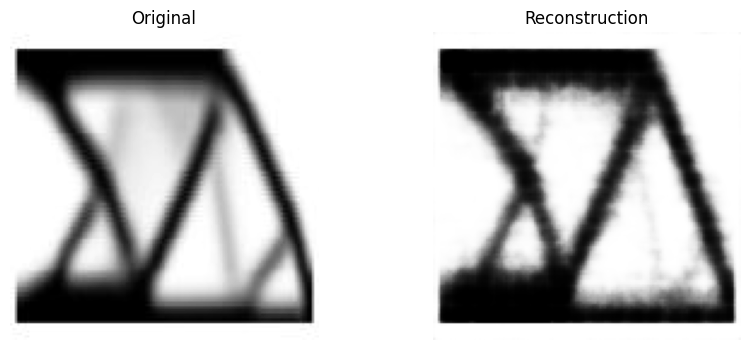


Epoch 5/5:
  Average loss = 0.007557
  MSE = 0.005444
  KL Divergence = 0.211311
  Beta*KLD = 0.002113
--------------------------------------------------


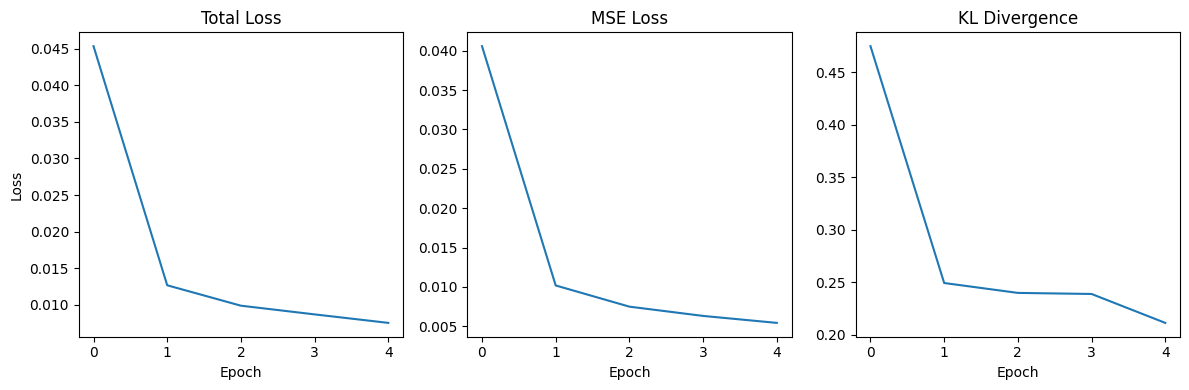

([0.04531920036877504,
  0.012687726633502427,
  0.009903710383533732,
  0.008716364345842434,
  0.007556694752985728],
 [0.0405707172611852,
  0.010194830885166503,
  0.007505067464095503,
  0.006327879597647905,
  0.005443580709045812],
 [0.47484831721260307,
  0.2492895798341003,
  0.23986429633977951,
  0.238848481970374,
  0.21131140854784247])

In [32]:
# Load and preprocess data
images, labels = load_data()
x_train, x_test, y_train, y_test = train_test_split(
    images, labels[:, 0], test_size=0.2, random_state=42
)

# Standardize y values
y_mean = y_train.mean()
y_std = y_train.std()
y_train_standardized = (y_train - y_mean) / y_std
y_test_standardized = (y_test - y_mean) / y_std

# Reshape y to (num_samples, 1)
y_train_standardized = y_train_standardized.reshape(-1, 1)
y_test_standardized = y_test_standardized.reshape(-1, 1)

# Create datasets and dataloaders
train_dataset = TopologyDataset(x_train, y_train_standardized)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'  # Use CPU for training
model = CVAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_cvae(model, train_loader, optimizer, device, epochs=5, beta=0.01)

## Visualization and Analysis Functions
Let's analyze both the model's performance and latent space properties:

### Reconstruction Visualization
Function: `visualize_reconstructions()` to compared original inputs with their reconstructions

### Latent Space Interpolation
Function: `interpolate_latent_space()` Performs linear interpolation between two random points in latent space at fixed conditions:
$z_\alpha = (1-\alpha)z_1 + \alpha z_2$, where $\alpha \in [0,1]$

### Conditional Generation
Function: `generate_variations()` Generates multiple designs for different volume fractions

### Latent Space Visualization
Function: `visualize_latent_space()` Maps all training samples to 2D latent space

1. Visualizing Reconstructions...


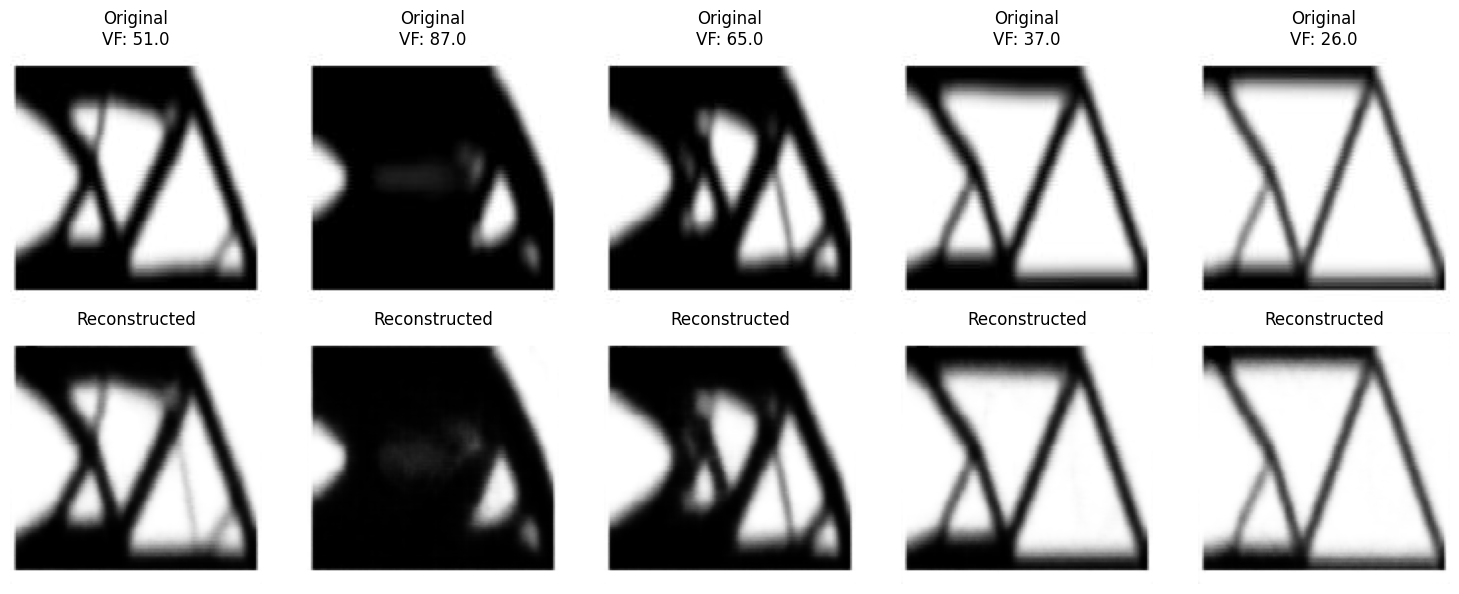


2. Interpolating in Latent Space...


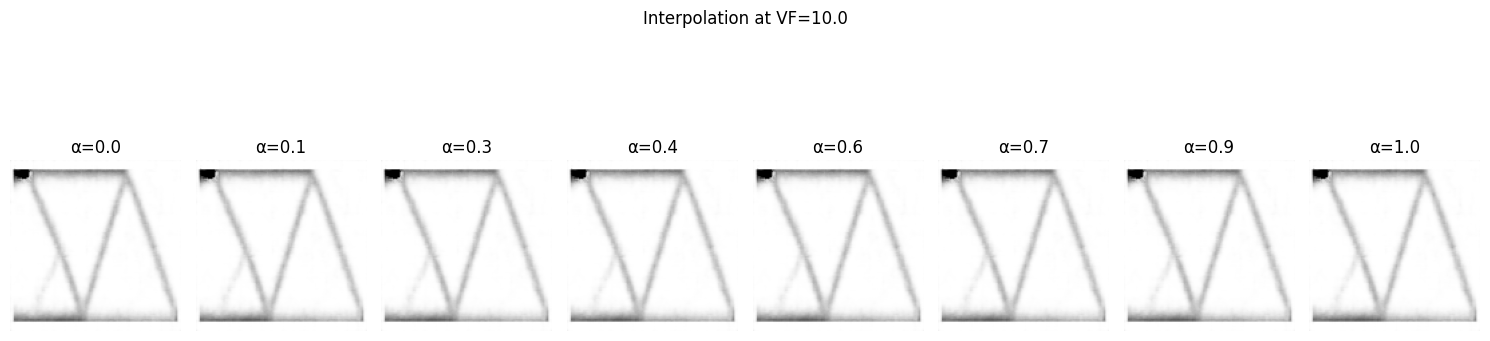


3. Generating Variations for Different Volume Fractions...


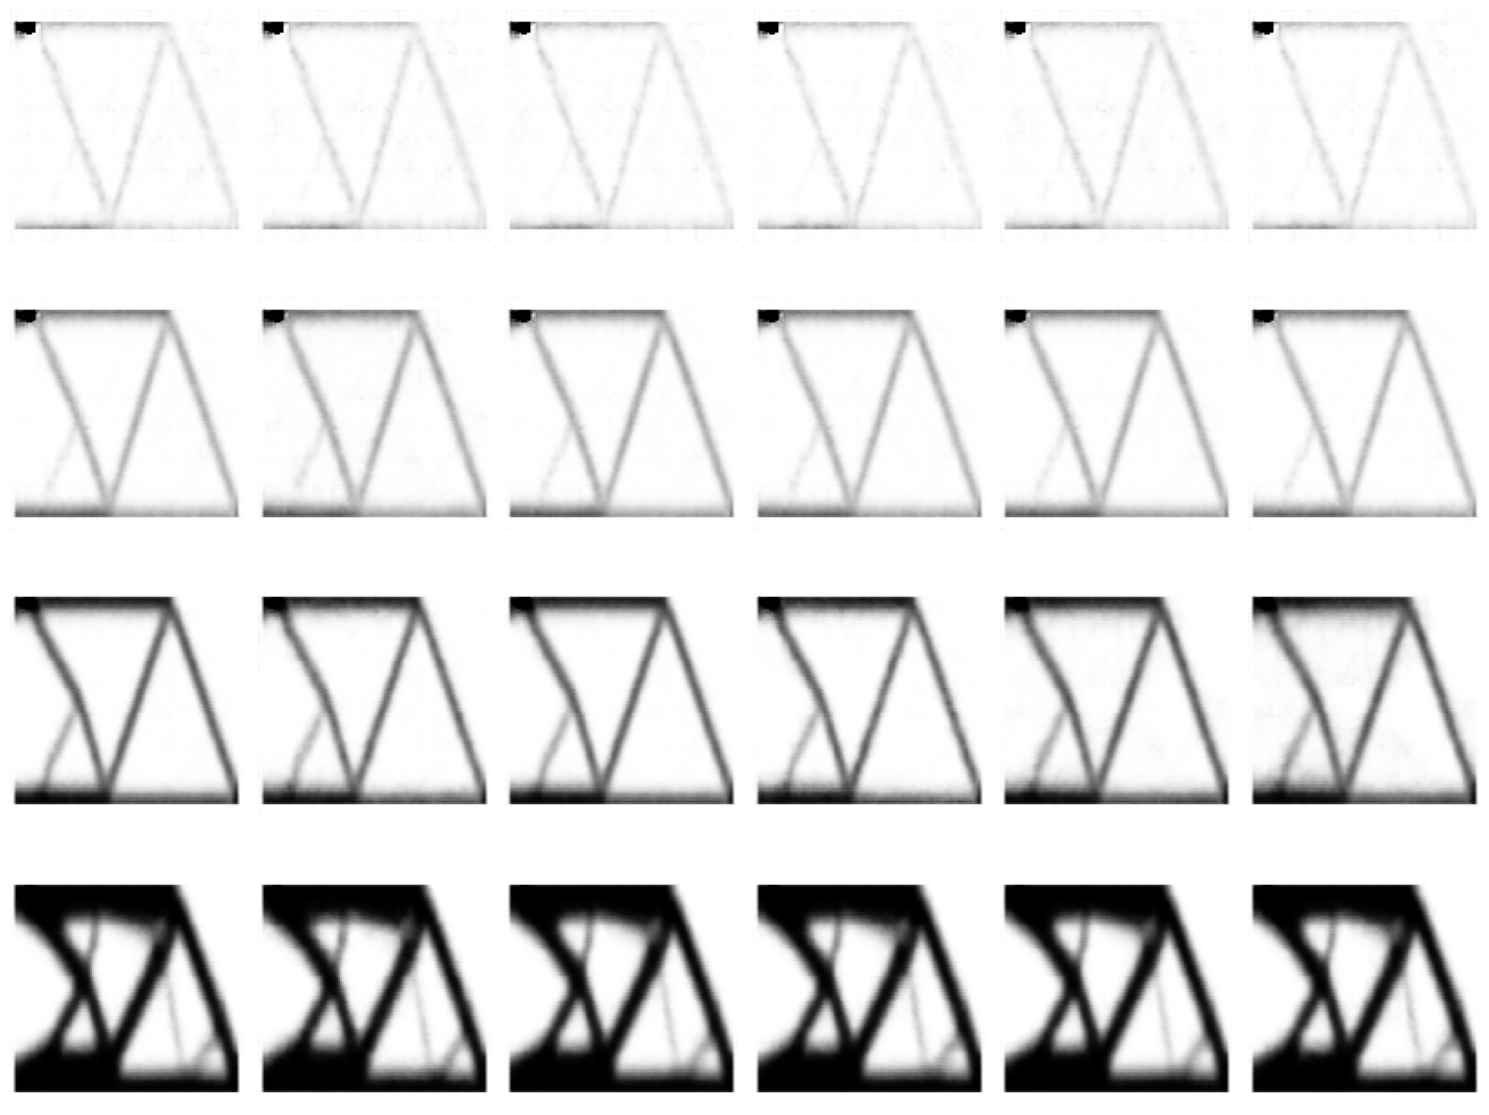

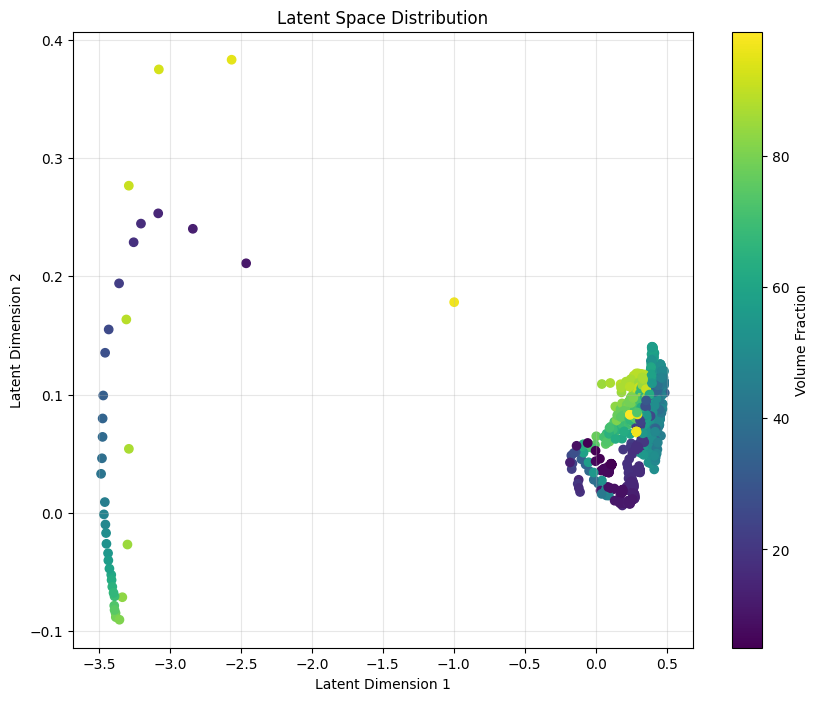


Latent Space Statistics:
Mean of dimension 1: 0.243
Mean of dimension 2: 0.082
Std of dimension 1: 0.513
Std of dimension 2: 0.035


In [28]:
def visualize_reconstructions(model, dataset, device, n_samples=5):
    """Visualize original and reconstructed images"""
    model.eval()
    fig = plt.figure(figsize=(15, 6))  # Made figure taller
    
    with torch.no_grad():
        for i in range(n_samples):
            # Get sample
            img, condition = dataset[i]
            img = img.unsqueeze(0).to(device)
            condition = condition.unsqueeze(0).to(device)
            
            # Reconstruct
            recon, _, _ = model(img, condition)
            
            # Convert condition back to original scale
            orig_condition = condition.item() * y_std + y_mean
            
            # Plot original
            plt.subplot(2, n_samples, i + 1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
            plt.title(f'Original\nVF: {orig_condition:.1f}')
            plt.axis('off')
            
            # Plot reconstruction
            plt.subplot(2, n_samples, i + 1 + n_samples)
            plt.imshow(recon.cpu().squeeze().numpy(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def interpolate_latent_space(model, condition_value, device, n_steps=10):
    """Generate images by interpolating in latent space"""
    model.eval()
    
    # Standardize condition value
    condition_standardized = (condition_value - y_mean) / y_std
    condition = torch.tensor([[condition_standardized]]).float().to(device)
    
    # Create latent space points
    z1 = torch.randn(1, model.latent_dim).to(device)
    z2 = torch.randn(1, model.latent_dim).to(device)
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, n_steps)
    
    # Generate and plot interpolated images
    plt.figure(figsize=(15, 4))
    
    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            # Interpolate in latent space
            z = alpha * z1 + (1 - alpha) * z2
            
            # Generate image
            img = model.decode(z, condition)
            
            # Plot
            plt.subplot(1, n_steps, i + 1)
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
            plt.axis('off')
            plt.title(f'α={alpha:.1f}')
    
    plt.suptitle(f'Interpolation at VF={condition_value:.1f}', y=1.05)
    plt.tight_layout()
    plt.show()

# Function to explore different volume fractions
def generate_variations(model, volume_fractions, device, n_samples=5):
    """Generate samples for different volume fractions"""
    model.eval()
    
    plt.figure(figsize=(15, 3*len(volume_fractions)))
    
    with torch.no_grad():
        for i, vf in enumerate(volume_fractions):
            # Standardize condition
            condition_standardized = (vf - y_mean) / y_std
            condition = torch.tensor([[condition_standardized]]).float().to(device)
            
            for j in range(n_samples):
                # Sample random latent vector
                z = torch.randn(1, model.latent_dim).to(device)
                
                # Generate image
                img = model.decode(z, condition)
                
                # Plot
                plt.subplot(len(volume_fractions), n_samples, i*n_samples + j + 1)
                plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
                plt.axis('off')
                if j == 0:
                    plt.ylabel(f'VF={vf:.1f}')
    
    plt.tight_layout()
    plt.show()

# Code to run visualizations
def run_visualizations(model, dataset, device):
    """Run all visualizations"""
    print("1. Visualizing Reconstructions...")
    visualize_reconstructions(model, dataset, device, n_samples=5)
    
    print("\n2. Interpolating in Latent Space...")
    interpolate_latent_space(model, condition_value=10, device=device, n_steps=8)
    
    print("\n3. Generating Variations for Different Volume Fractions...")
    volume_fractions = [0.3, 10, 20, 50]
    generate_variations(model, volume_fractions, device, n_samples=6)

# Run all visualizations
run_visualizations(model, train_dataset, device)


def visualize_latent_space(model, dataset, device):
    """Visualize the latent space encodings"""
    model.eval()
    encodings = []
    conditions = []
    
    # Get encodings for all data points
    with torch.no_grad():
        for data, condition in dataset:
            # Prepare input
            data = data.unsqueeze(0).to(device)
            condition = condition.unsqueeze(0).to(device)
            
            # Get latent space representation (mu)
            mu, _ = model.encode(data, condition)
            
            # Store results
            encodings.append(mu.cpu().numpy())
            conditions.append(condition.cpu().numpy())
    
    # Convert to numpy arrays
    encodings = np.vstack(encodings)
    conditions = np.vstack(conditions)
    
    # Convert standardized conditions back to original scale
    original_conditions = conditions * y_std + y_mean
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encodings[:, 0], encodings[:, 1], 
                         c=original_conditions[:, 0],
                         cmap='viridis')
    plt.colorbar(scatter, label='Volume Fraction')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return encodings, conditions

# Run the visualization
encodings, conditions = visualize_latent_space(model, train_dataset, device)



## Outlier Analysis in Latent Space

The `plot_outlier_samples()` function identifies and visualizes outlier designs based on their latent space encodings. 

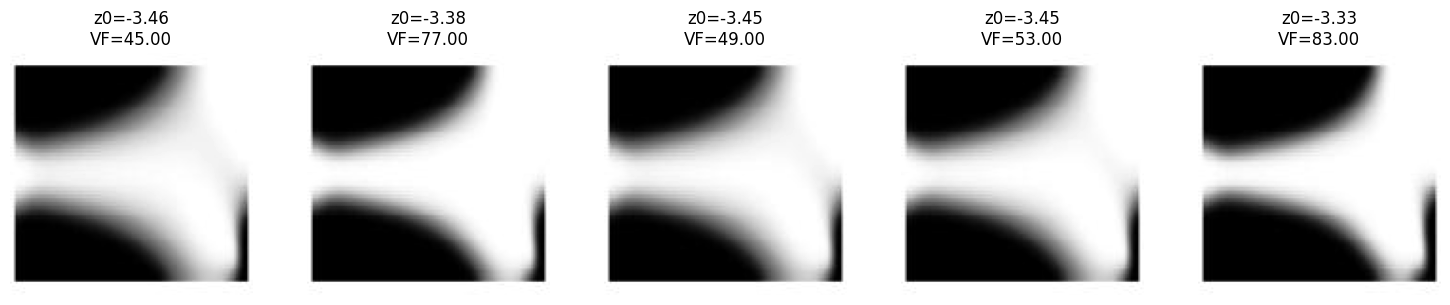

In [31]:
def plot_outlier_samples(model, dataset, device, dimension=0, threshold=-3):
    """
    Plot samples where the specified latent dimension is less than threshold
    """
    model.eval()
    selected_images = []
    selected_codes = []
    selected_conditions = []
    
    # Collect samples
    with torch.no_grad():
        for data, condition in dataset:
            # Get encoding
            data = data.unsqueeze(0).to(device)
            condition = condition.unsqueeze(0).to(device)
            mu, _ = model.encode(data, condition)
            
            # Check if first dimension meets criterion
            if mu[0, dimension].item() < threshold:
                selected_images.append(data.cpu().squeeze().numpy())
                selected_codes.append(mu.cpu().squeeze().numpy())
                selected_conditions.append(condition.cpu().item() * y_std + y_mean)
    
    # Plot samples
    n_samples = min(5, len(selected_images))
    if n_samples > 0:
        plt.figure(figsize=(15, 3))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(selected_images[i], cmap='gray')
            plt.title(f'z{dimension}={selected_codes[i][dimension]:.2f}\nVF={selected_conditions[i]:.2f}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No samples found meeting the criteria")

# Plot samples where first latent dimension < 3
plot_outlier_samples(model, train_dataset, device, dimension=0, threshold=-3)